In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import scipy.stats as sts
import matplotlib.cm

import os
import pickle

import SAM
import float_data as flt

import importlib
importlib.reload(SAM)
importlib.reload(flt)

from dask import delayed

Starting r1i1p1f2
Finished setup for r1i1p1f2


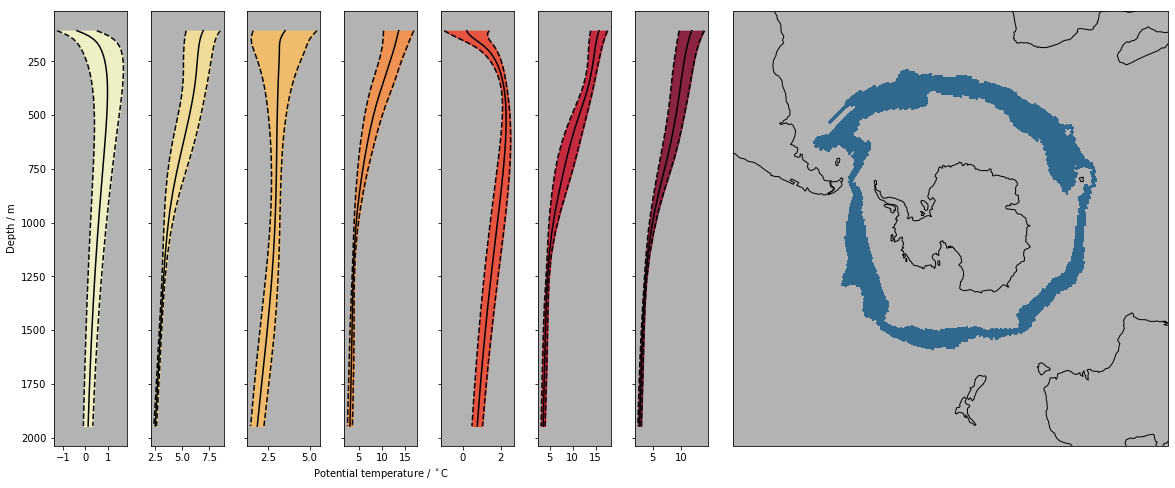

0
Starting r2i1p1f2
Finished setup for r2i1p1f2


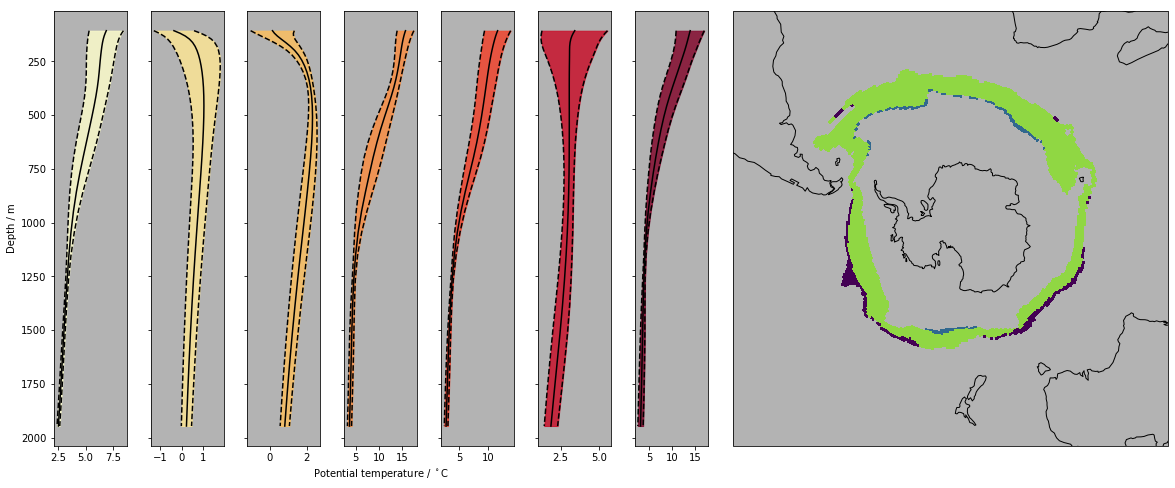

0
Done!


In [2]:
model_folder = 'model'
n_classes = 7
ids = ['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2', 'r5i1p1f3', 'r6i1p1f3', 'r7i1p1f3', 'r8i1p1f2', 'r9i1p1f2', 'r10i1p1f2']
ids = ['r1i1p1f2', 'r2i1p1f2']
mask = np.load('data/mask.npy', allow_pickle=True)
#data_classes = {}
avg_profiles_dict = {}
path_ref = 'data/{}/{}'.format(ids[0], n_classes)
with open('{}/avg.obj'.format(path_ref), 'rb') as file:
    ref_profiles = pickle.load(file)
    inds = flt.temp_sort(None, ref_profiles, True)
    ref_profiles = [ref_profiles[x] for x in inds]
    file.close()
    
for (m_i, m_id) in enumerate(ids):

  print('Starting {}'.format(m_id))
  path_id = '{}/{}'.format(model_folder, m_id)
  path_n = '{}/{}/{}'.format(model_folder, m_id, n_classes)
  path_data = 'data/{}/{}'.format(m_id, n_classes)

  with open('{}/pca.obj'.format(path_id), 'rb') as file:
      pca = pickle.load(file)
      file.close()

  with open('{}/gmm.obj'.format(path_n), 'rb') as file:
      gmm = pickle.load(file)
      file.close()

  with open('{}/avg.obj'.format(path_data), 'rb') as file:
      avg_profiles = pickle.load(file)
      file.close()

  options = {'memberId' : m_id, 'raw' : True}
  data = flt.retrieve_profiles(timeRange = slice('1970-01', '1970-01'), mask=mask, options=options)
  data_sampled = flt.normalise_data(data, ('i', 'j', 'time'))
  data_trans = flt.pca_transform(data_sampled, pca)
  data_c = flt.gmm_classify(data_trans, gmm)

  print('Finished setup for {}'.format(m_id))

  inds_m = flt.match_profiles(ref_profiles, avg_profiles)    

  data_c = flt.reorder(data_c, inds_m)
  avg_profiles = [avg_profiles[x] for x in inds_m]
  avg_profiles_dict[m_id] = avg_profiles
  lats = data_c['lat'].values
  lons = data_c['lon'].values
  lev = data['lev'].values

  plt_data = data_c.values
  alpha = np.logical_not(data.isel(time=0, lev=-1).isnull().values)
  if m_i == 0:
    alpha1 = data_c.values == 2
  alpha = np.logical_and(alpha1, alpha)
  plt_data[plt_data == -1] = 0
  for yr in range(np.size(plt_data, 0)):
    
    cmap = matplotlib.cm.get_cmap('YlOrRd')
    
    wr = np.ones(n_classes + 1)
    wr[-1] = 6
    fig = plt.figure()
    gs = fig.add_gridspec(1, n_classes + 1, width_ratios=wr)
    
    
  
    ax = fig.add_subplot(gs[:, -1], projection=ccrs.SouthPolarStereo())
    ax.pcolormesh(lons, lats, plt_data[yr, :, :], transform=ccrs.PlateCarree(), alpha=alpha, cmap='YlOrRd') #, cmap='YlOrRd'
    ax.coastlines()
    ax.set_facecolor((0.7, 0.7, 0.7, 1))
    #fig.suptitle(m_id)
    
    for k in range(n_classes):
      
      rgba = list(cmap(k / (n_classes - 1)))
      rgba[-1] = 0.8
      
      ax = fig.add_subplot(gs[:, k])
      if k != 0:
        ax.set_yticklabels([])
      else:
        plt.ylabel('Depth / m')
      ax.plot(avg_profiles[k]['mean'], lev, c='black')
      x2 = avg_profiles[k]['mean'] + avg_profiles[k]['std']
      x1 = avg_profiles[k]['mean'] - avg_profiles[k]['std']
      ax.plot(x2, lev, c='black', ls='--')
      ax.plot(x1, lev, c='black', ls='--')
      ax.fill_betweenx(lev, x1, x2, color=rgba)
      ax.set_facecolor((0.7, 0.7, 0.7, 1))
      ax.invert_yaxis()
      #ax.set_xlim(-1, 20)
    fig.add_subplot(gs[:, 0:-1], frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel('Potential temperature / ${}^\circ$C')
    
    fig.set_size_inches(20, 8)
    plt.savefig('figures/c3-{}'.format(m_id), dpi=300, bbox_inches='tight')
    plt.show()
    print(yr)
    ax.clear()
  break
print('Done!')

In [5]:
np.unique(plt_data)

array([0, 1, 2, 3, 4, 5, 6])

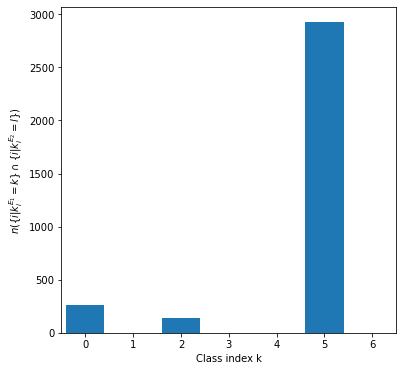

In [26]:
(a, b) = np.unique(plt_data[alpha], return_counts=True)
f = plt.figure()
plt.bar(a, b)
plt.xlabel('Class index k')
plt.xlim([-0.5, 6.5])
plt.ylabel('$n(\{i | k_i^{E_1} = k\} \cap \{i | k_i^{E_2} = l\})$')
f.set_size_inches(6, 6)
plt.savefig('figures/c3-{}'.format(m_id), dpi=300, bbox_inches='tight')